<a href="https://colab.research.google.com/github/fxnnxc/NLP_visualization/blob/master/Domain_specific_ranking_using_word2vec_cosine_distance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec을 활용한 단어 시각화


1. 이미 학습된 모델 Word2Vec을 활용한 유사단어 ⭐⭐⭐

        coffee와 유사한 단어
        tea        : 69.4%
        cocoa      : 64.3%
        beans      : 61.9%
        espresso   : 61.3%
        drinks     : 60.4%
        drink      : 58.9%
        beer       : 58.7%
        wine       : 58.4%
        starbucks  : 58.2%
        sugar      : 55.7%


2. 나라 분류 모델 만들기 ⭐

        나라로 분류한 단어: ['senegal', 'latvia', 'colombia', 'serbia', 'nepal', 'maldives', 'croatia', 'brazil', 'uganda', 'slovakia']
        나라가   아닌 단어 :['qbs', 'allmänna', '1,617', 'zingiber', 'petticoats', 'drab', 'influx', '22-room', 'ares', 'lilith']


3. 단어의 나라별 유사도 랭킹 찾기 ⭐⭐⭐


            name      cold(단어)
        18    Russia  1.000000
        124   Turkey  0.875073
        113   Poland  0.857130
        87      Iraq  0.818083
        139    China  0.811328
        76    Israel  0.798129
        94   Vietnam  0.792054
        107     Iran  0.715305
        98     India  0.701055
        121  Germany  0.688784

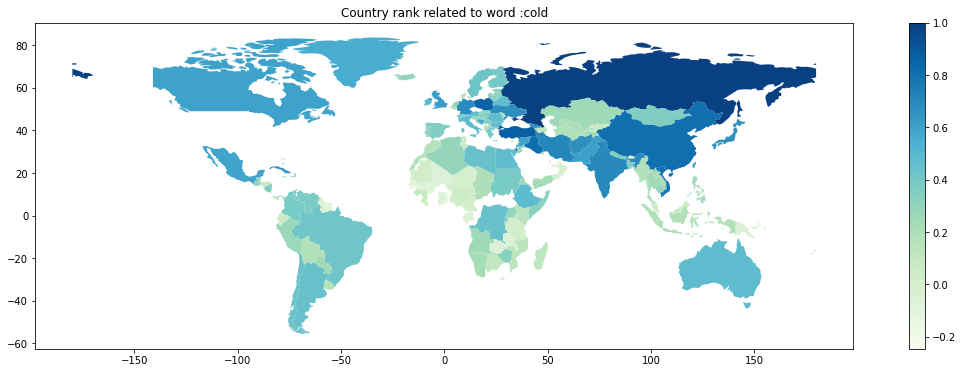


## 라이브러리 불러오기

In [ ]:
! pip install geopandas

In [ ]:
%matplotlib inline

from sklearn import svm
from keras.utils import get_file
import os
import gensim
import subprocess
import numpy as np
import random
import requests
import geopandas as gpd
import pandas as pd
from IPython.core.pylabtools import figsize
import csv
import matplotlib.pyplot as plt

figsize(12, 8)

# 이미 학습된 모델 Word2Vec  ⭐⭐⭐
 
https://github.com/RaRe-Technologies/gensim-data

* glove-wiki-gigaword-200 : 40만 단어 250 MB
*  word2vec-google-news-300 : 300만 단어. 1.6 G인데 Colab에서 쓰기에는 너무 크다.

In [ ]:
import gensim.downloader as api

model = api.load('glove-wiki-gigaword-200')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
lst = model.most_similar(positive=['coffee'])
print("coffee와 유사한 단어")
for i in lst:
    print(f"{i[0]:10s} : {i[1]*100:.1f}%")

coffee와 유사한 단어
tea        : 69.4%
cocoa      : 64.3%
beans      : 61.9%
espresso   : 61.3%
drinks     : 60.4%
drink      : 58.9%
beer       : 58.7%
wine       : 58.4%
starbucks  : 58.2%
sugar      : 55.7%


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


# 나라 분류 모델 만들기 ⭐

In [ ]:
countries = list(csv.DictReader(open('/content/countries.csv')))
countries = [i for i in countries if i['name'].lower() in model.vocab]
for i in range(len(countries)):
    countries[i]['name'] = countries[i]['name'].lower()
len(countries)

161

In [ ]:
positive = [x['name'].lower() for x in random.sample(countries, 40)]
negative = random.sample(model.vocab.keys(), 5000)
negative[:4]

['3-1-3', 'meno', 'nestea', 'hexafluorophosphate']

In [ ]:
labelled = [(p, 1) for p in positive] + [(n, 0) for n in negative]
random.shuffle(labelled)
X = np.asarray([model[w] for w, l in labelled])
y = np.asarray([l for w, l in labelled])
X.shape, y.shape

((5040, 200), (5040,))

In [ ]:
TRAINING_FRACTION = 0.3
cut_off = int(TRAINING_FRACTION * len(labelled))
clf = svm.SVC(kernel='linear')
clf.fit(X[:cut_off], y[:cut_off])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
res = clf.predict(X[cut_off:])

correct = [country for (pred, truth, country) in 
 zip(res, y[cut_off:], labelled[cut_off:]) if pred == truth]
print("나라로 분류한 단어: ", end="")
print([i[0] for i in correct if i[1]==1][:10]) 
print("나라가   아닌 단어 :", end="")
print([i[0] for i in correct if i[1]==0][:10]) 

나라로 분류한 단어: ['senegal', 'latvia', 'colombia', 'serbia', 'nepal', 'maldives', 'croatia', 'brazil', 'uganda', 'slovakia']
나라가   아닌 단어 :['qbs', 'allmänna', '1,617', 'zingiber', 'petticoats', 'drab', 'influx', '22-room', 'ares', 'lilith']


# 단어의 나라별 유사도 랭킹 찾기 ⭐⭐⭐

In [ ]:
country_to_idx = {country['name']: idx for idx, country in enumerate(countries)}
country_vecs = np.asarray([model[c['name']] for c in countries])
country_vecs.shape

(161, 200)

In [ ]:
def rank_countries(term, topn=10, field='name'):
    if not term in model:
        return []
    vec = model[term]
    dists = np.dot(country_vecs, vec)
    return [(countries[idx][field], float(dists[idx])) 
            for idx in reversed(np.argsort(dists)[-topn:])]

In [ ]:
rank_countries('cricket')

[('pakistan', 30.829076766967773),
 ('england', 30.294883728027344),
 ('bangladesh', 26.315738677978516),
 ('australia', 25.949237823486328),
 ('zimbabwe', 25.534557342529297),
 ('india', 24.79012680053711),
 ('fiji', 19.207700729370117),
 ('ireland', 18.129230499267578),
 ('barbados', 17.776710510253906),
 ('kenya', 17.58966827392578)]

Text(0.5, 1.0, 'World Map')

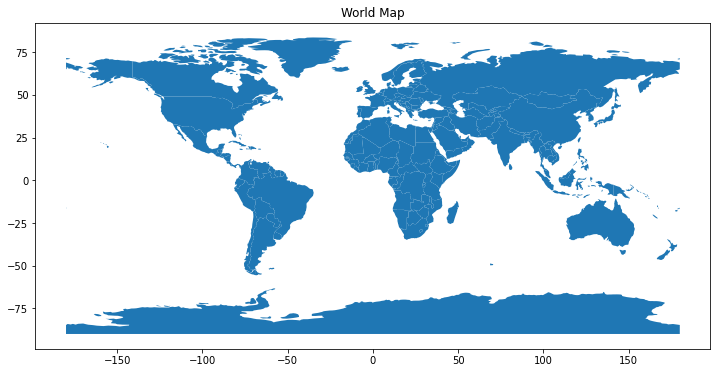

In [ ]:
figsize(20,6)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()
world.plot()
plt.title("World Map")

In [ ]:
figsize(20,6)
def map_term(term):
    d = {k.upper(): v for k, v in rank_countries(term, topn=0, field='cc3')}
    world[term] = world['iso_a3'].map(d)
    world[term] /= world[term].max()
    world.dropna().plot(term, cmap='GnBu', legend=True)
    print(world[['name',term]].sort_values(by=term, ascending=False)[:10])
    plt.title("Country rank related to word :" + term);

        name      cold
18    Russia  1.000000
124   Turkey  0.875073
113   Poland  0.857130
87      Iraq  0.818083
139    China  0.811328
76    Israel  0.798129
94   Vietnam  0.792054
107     Iran  0.715305
98     India  0.701055
121  Germany  0.688784


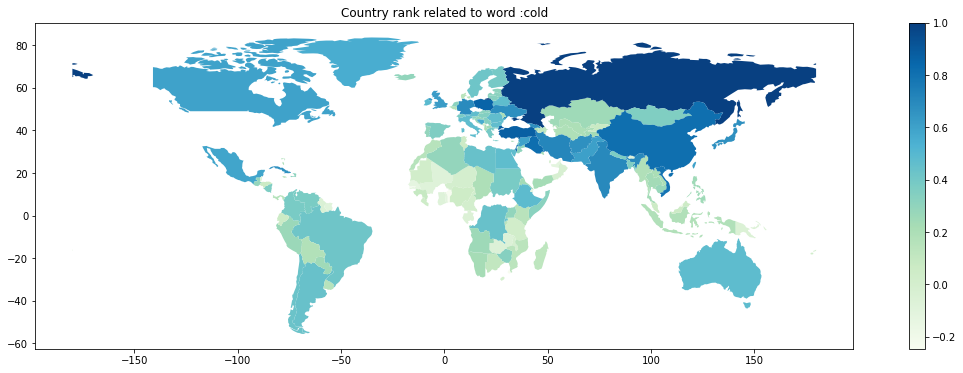

In [ ]:
# ---------------------------------
# 단어 입력

word = 'cold'

# ---------------------------------
map_term(word)

         name       car
87       Iraq  1.000000
121   Germany  0.932370
139     China  0.914105
141     Italy  0.889942
155     Japan  0.887850
83     Jordan  0.881622
102  Pakistan  0.854043
76     Israel  0.848330
98      India  0.842978
77    Lebanon  0.842522


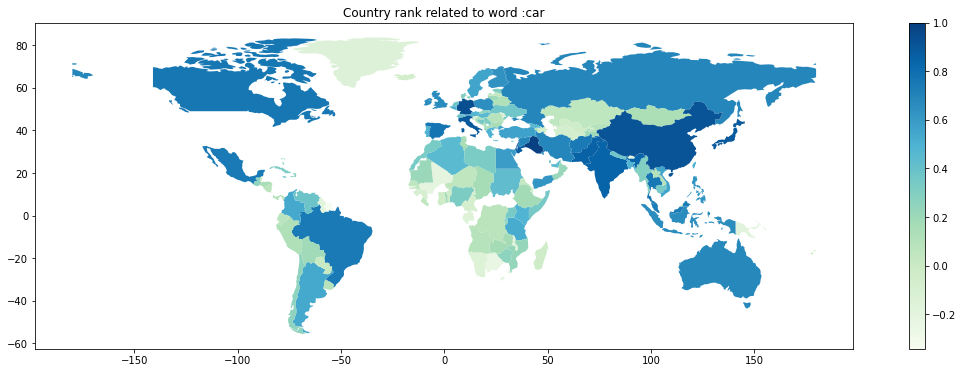

In [ ]:
# ---------------------------------
# 단어 입력

word = 'car'

# ---------------------------------
map_term(word)